In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os
from pathlib import Path
import seaborn as sns
sns.set_style("whitegrid")

# set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [4]:
DATA_PATH = "~/Anomaly-Detection-Auto-Encoder/data"
WINDOW_SIZE = 60
BATCH_SIZE = 64
SEQ_LEN = 1  # Single timestep per sequence for LSTM

# Load and combine normal data
normal_files = ["sine.csv", "sawtooth.csv", "square.csv"]
dfs = []

for file in normal_files:
    df = pd.read_csv(Path(DATA_PATH)/file).drop(columns=['timestamp'])
    dfs.append(df)

full_df = pd.concat(dfs, ignore_index=True)
print(f"Total samples: {len(full_df)}")

# Normalize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(full_df)

Total samples: 32771


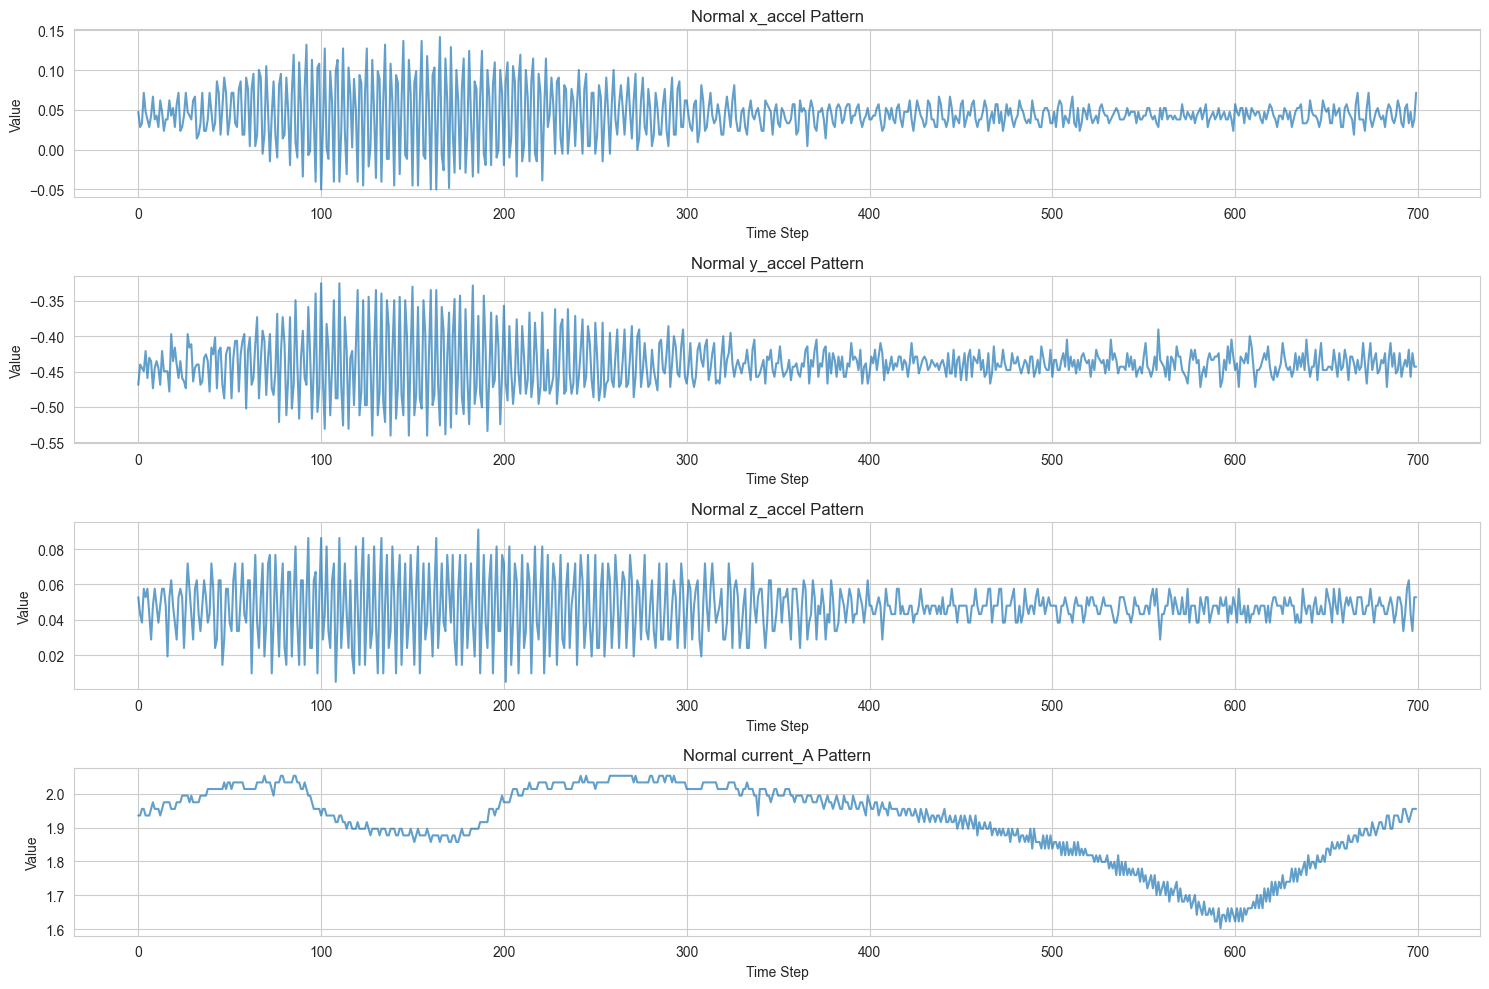

In [5]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(full_df.columns):
    plt.subplot(4, 1, i+1)
    plt.plot(full_df[col].values[:700], alpha=0.7)
    plt.title(f'Normal {col} Pattern')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
plt.tight_layout()
plt.show()

In [6]:
def create_sequences(data, window_size):
    """Create overlapping sequences with sliding window"""
    sequences = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i+window_size])
    return np.array(sequences)

# Create sequences and split
sequences = create_sequences(scaled_data, WINDOW_SIZE)
X_train, X_val = train_test_split(sequences, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
train_data = torch.FloatTensor(X_train)
val_data = torch.FloatTensor(X_val)

train_loader = DataLoader(TensorDataset(train_data, train_data), 
                       batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(val_data, val_data), 
                      batch_size=BATCH_SIZE)

In [10]:
class LSTM_Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len):
        super().__init__()
        self.input_dim = input_dim    # 4 features (x,y,z accel + current)
        self.hidden_dim = hidden_dim  # Latent space dimension
        self.seq_len = seq_len        # Window size
        
        # Encoder
        self.encoder = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            batch_first=True
        )
        
        # Decoder
        self.decoder = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            batch_first=True
        )
        
        # Final feature reconstruction
        self.fc = nn.Linear(hidden_dim, input_dim)
        
    def forward(self, x):
        # Encoder
        _, (hidden, cell) = self.encoder(x)
        
        # Decoder input (initialized with zeros)
        decoder_input = torch.zeros(x.size(0), self.seq_len, self.hidden_dim).to(x.device)
        
        # Decoder with encoder's hidden state
        decoder_output, _ = self.decoder(decoder_input, (hidden, cell))
        
        # Reconstruct original features
        return self.fc(decoder_output)

# Initialize model
WINDOW_SIZE = 60
model = LSTM_Autoencoder(
    input_dim=4,     # x_accel, y_accel, z_accel, current_A
    hidden_dim=32,   # Latent dimension
    seq_len=WINDOW_SIZE
)
print(model)

LSTM_Autoencoder(
  (encoder): LSTM(4, 32, batch_first=True)
  (decoder): LSTM(32, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=4, bias=True)
)


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Verify dimensions
test_input = torch.randn(64, WINDOW_SIZE, 4).to(device)  # Batch size 64
test_output = model(test_input)
print(f"Input shape: {test_input.shape}")   # Should be torch.Size([64, 60, 4])
print(f"Output shape: {test_output.shape}") # Should be torch.Size([64, 60, 4])

# Training loop
NUM_EPOCHS = 100
train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0
    for batch in train_loader:
        inputs = batch[0].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs = batch[0].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item()
    
    # Record losses
    epoch_train_loss = train_loss/len(train_loader)
    epoch_val_loss = val_loss/len(val_loader)
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    
    print(f'Epoch {epoch+1}/{NUM_EPOCHS} | '
          f'Train Loss: {epoch_train_loss:.4f} | '
          f'Val Loss: {epoch_val_loss:.4f}')

Input shape: torch.Size([64, 60, 4])
Output shape: torch.Size([64, 60, 4])
Epoch 1/100 | Train Loss: 0.8633 | Val Loss: 0.7963
Epoch 2/100 | Train Loss: 0.7792 | Val Loss: 0.7794
Epoch 3/100 | Train Loss: 0.7725 | Val Loss: 0.7767
Epoch 4/100 | Train Loss: 0.7684 | Val Loss: 0.7718
Epoch 5/100 | Train Loss: 0.7669 | Val Loss: 0.7711
Epoch 6/100 | Train Loss: 0.7631 | Val Loss: 0.7684
Epoch 7/100 | Train Loss: 0.7613 | Val Loss: 0.7665
Epoch 8/100 | Train Loss: 0.7615 | Val Loss: 0.7679
Epoch 9/100 | Train Loss: 0.7614 | Val Loss: 0.7676
Epoch 10/100 | Train Loss: 0.7578 | Val Loss: 0.7629
Epoch 11/100 | Train Loss: 0.7566 | Val Loss: 0.7628
Epoch 12/100 | Train Loss: 0.7561 | Val Loss: 0.7620
Epoch 13/100 | Train Loss: 0.7560 | Val Loss: 0.7621
Epoch 14/100 | Train Loss: 0.7558 | Val Loss: 0.7618
Epoch 15/100 | Train Loss: 0.7558 | Val Loss: 0.7617
Epoch 16/100 | Train Loss: 0.7560 | Val Loss: 0.7618
Epoch 17/100 | Train Loss: 0.7559 | Val Loss: 0.7617
Epoch 18/100 | Train Loss: 0.7557

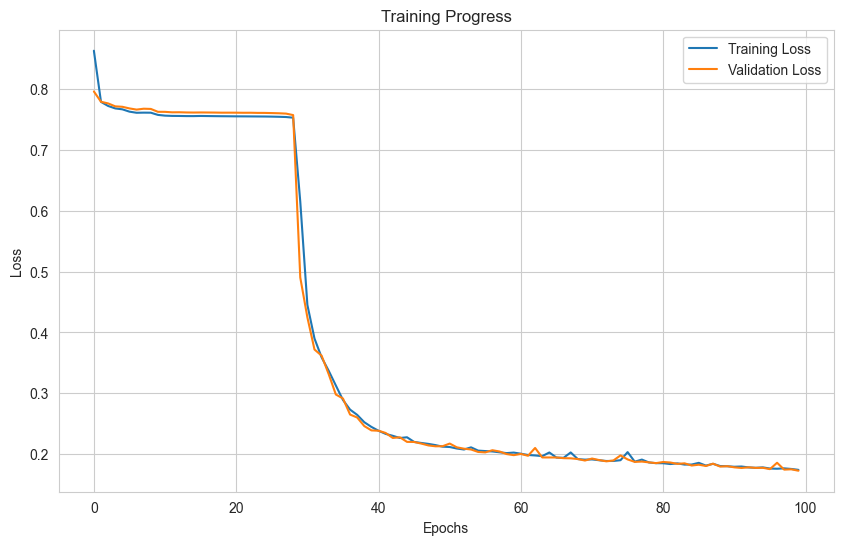

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training Progress')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Anomaly Threshold: 0.4982


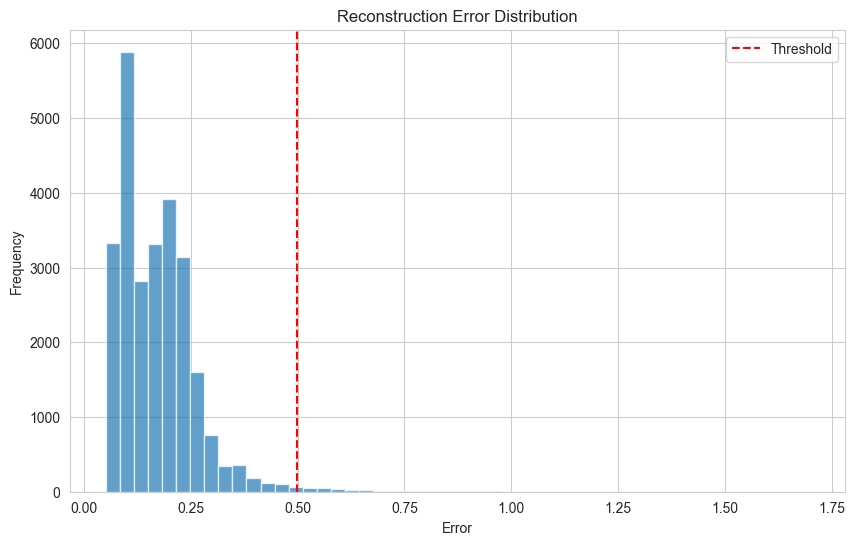

In [13]:
model.eval()
reconstruction_errors = []

with torch.no_grad():
    for batch in train_loader:
        inputs = batch[0].to(device)
        outputs = model(inputs)
        error = torch.mean((outputs - inputs)**2, dim=(1,2)).cpu().numpy()
        reconstruction_errors.extend(error)

threshold = np.percentile(reconstruction_errors, 99)
print(f"Anomaly Threshold: {threshold:.4f}")

# Plot error distribution
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_errors, bins=50, alpha=0.7)
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [14]:
def detect_anomalies(file_path, model, scaler, threshold):
    # Load and preprocess data
    df = pd.read_csv(file_path).drop(columns=['timestamp'])
    scaled_data = scaler.transform(df.values)
    sequences = create_sequences(scaled_data, WINDOW_SIZE)
    
    # Predict and calculate errors
    test_loader = DataLoader(TensorDataset(torch.FloatTensor(sequences)), 
                           batch_size=BATCH_SIZE)
    
    errors = []
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            inputs = batch[0].to(device)
            outputs = model(inputs)
            batch_errors = torch.mean((outputs - inputs)**2, dim=(1,2)).cpu().numpy()
            errors.extend(batch_errors)
    
    # Detect anomalies
    anomalies = np.array(errors) > threshold
    return df, errors, anomalies

/Users/paras/Anomaly-Detection-Auto-Encoder/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


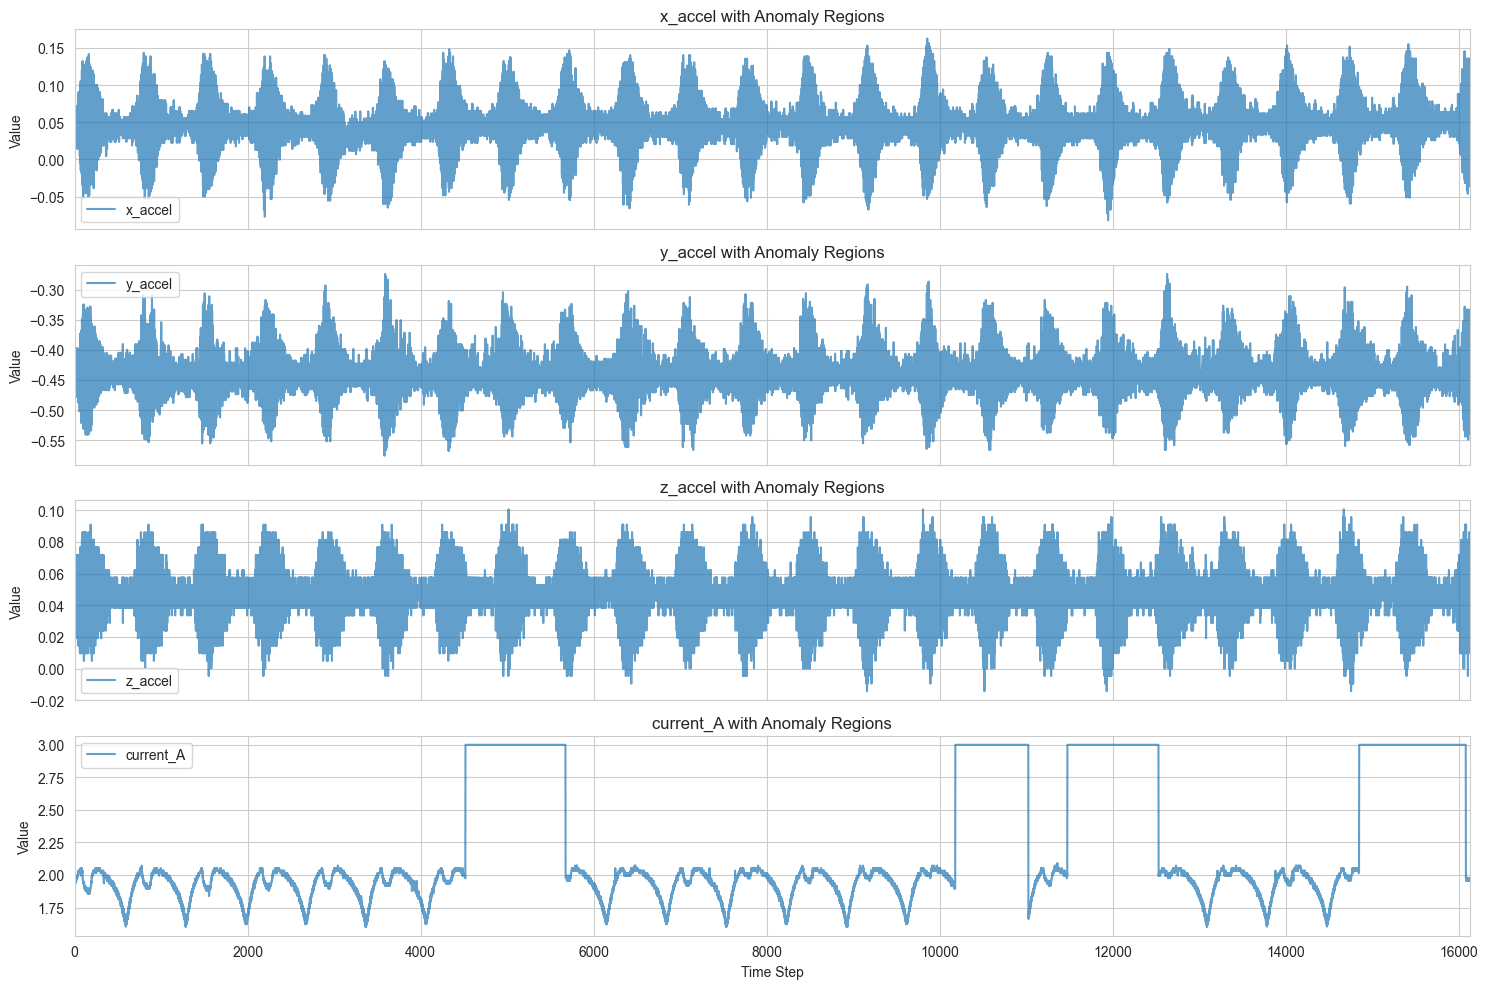

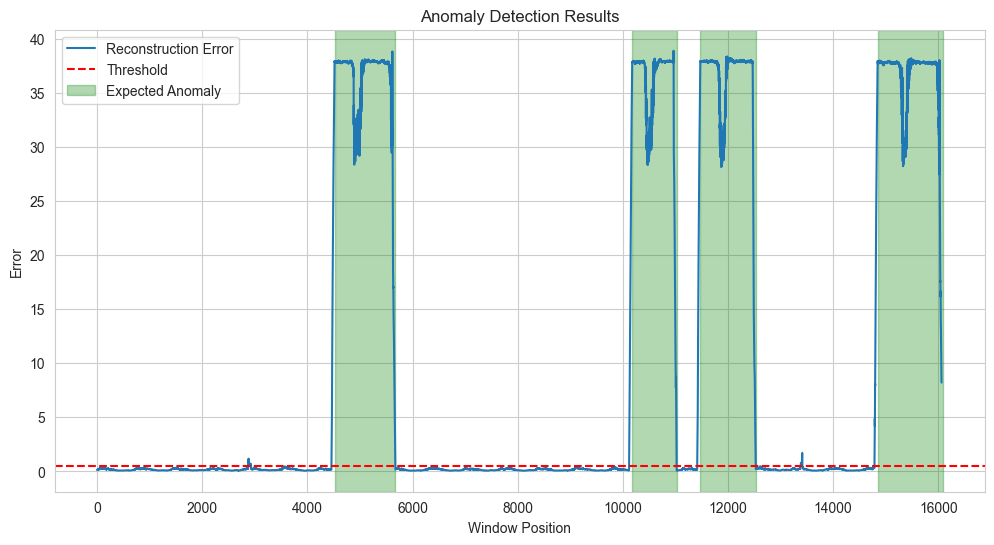

In [16]:
test_file = "sineanom.csv"  
raw_data, errors, anomalies = detect_anomalies(test_file, model, scaler, threshold)

# Plot sensor readings with shared x-axis
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 10), sharex=True)
for i, (ax, col) in enumerate(zip(axes, raw_data.columns)):
    ax.plot(raw_data[col], alpha=0.7, label=col)
    
    # Mark anomaly regions based on your sliding window approach:
    anomaly_indices = np.where(anomalies)[0] * WINDOW_SIZE
    for idx in anomaly_indices:
        ax.axvspan(idx, idx+WINDOW_SIZE, color='red', alpha=0.3)
    
    ax.set_title(f'{col} with Anomaly Regions')
    ax.set_ylabel('Value')
    ax.legend()
    
axes[-1].set_xlabel('Time Step')
axes[-1].set_xlim(0, len(raw_data))
plt.tight_layout()
plt.show()

# Plot error progression with additional green highlighted regions
plt.figure(figsize=(12, 6))
plt.plot(errors, label='Reconstruction Error')
plt.axhline(threshold, color='r', linestyle='--', label='Threshold')

# Expected anomaly regions highlighted in green
expected_regions = [(4519, 5675), (10180, 11024), (11475, 12528), (14847, 16079)]
for start, end in expected_regions:
    plt.axvspan(start, end, color='green', alpha=0.3, label='Expected Anomaly')

# Avoid duplicate labels in the legend
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
plt.legend(unique.values(), unique.keys())

plt.title('Anomaly Detection Results')
plt.xlabel('Window Position')
plt.ylabel('Error')
plt.show()

In [17]:
torch.save(model.state_dict(), "lstm_autoencoder.pth")